In [1]:
import sys
import json

with open('./paths', 'r') as f:
    globals().update(json.loads(f.read()))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import importlib
from scipy import optimize
from IPython.display import display

import sklearn.preprocessing as skprep
import sklearn.metrics as skmet
%matplotlib inline

In [3]:
sys.path.append(path_Modules_Product_)
sys.path.append(path_Modules_Toolbox_)

In [4]:
import plots as myplots
import handles as myhandles
import data_processing as myprep

In [5]:
from keras import layers as klayers
from keras import models as kmodels
from keras import callbacks as kcallbacks
from keras import regularizers as kregularizers
from keras import losses as kloss
from keras import backend as K
from keras import utils as kutils
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [6]:
dataset = myhandles.canseek_load(
    path_data_proprocessed_, folds=[[0, 1, 2], [3]])
ddef = pd.read_excel(path_data_proprocessed_ +
                     'dataset_main.xlsx', sheet_name=1, index_col=0)
cancer_sets = ['Colorectum', 'Lung', 'Breast', 'Ovary', 'Stomach', 'Esophagus']
normal_set = 'Normal'
all_sets = copy.deepcopy(cancer_sets)
all_sets.append(normal_set)
cv_data = pd.read_excel(path_data_proprocessed_ +
                        'P1_CV.xlsx', index_col=[0, 1])
for i in [0, 1, 2]:
    dataset[i] = myhandles.subset_selector(dataset[i], all_sets, 'T1')

In [7]:
features_name = ['CEA', 'AFP', 'CA15-3', 'CA19-9', 'CA-125', 'CYFRA21-1', 'HE4',
                 'Prolactin', 'Leptin', 'OPN', 'HGF', 'sFas', 'IL-6', 'IL-8', 'TGFa']
features = [['F1', 'F2'], myhandles.name_to_alias(features_name, ddef)]
features_set = np.concatenate(features)
targets = [['S1', 'S2', 'S3']]
targets_set = np.concatenate(targets)
data_set = np.concatenate([features_set, targets_set])

# CV data analysis

/home/amir/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/home/amir/miniconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


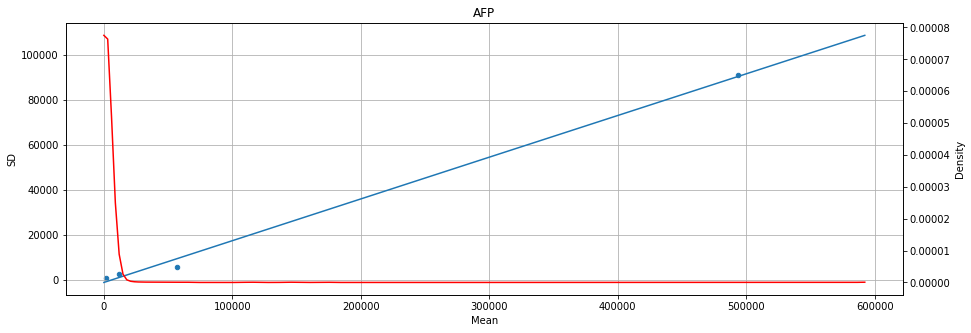

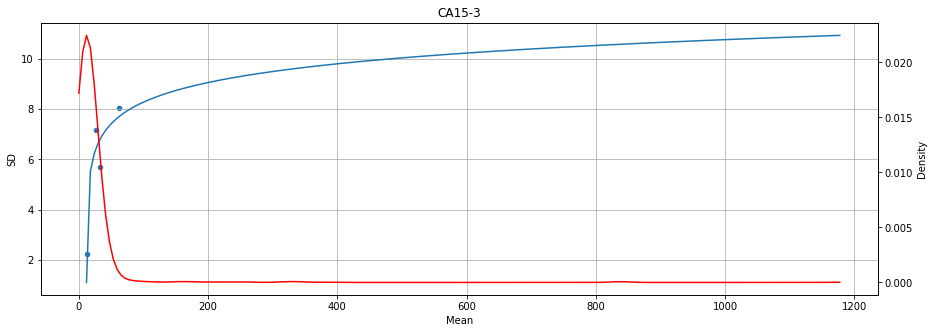

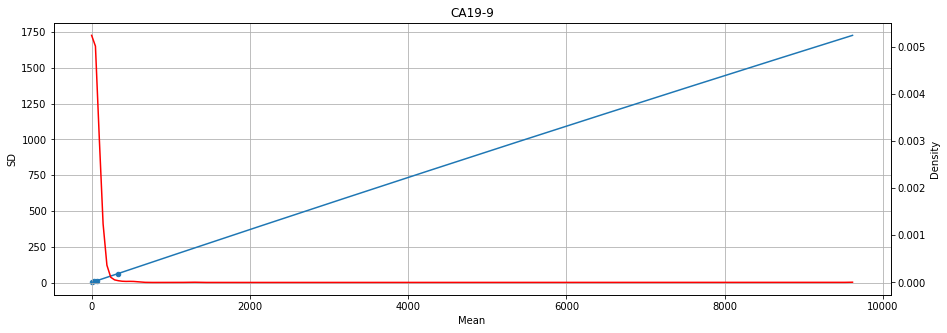

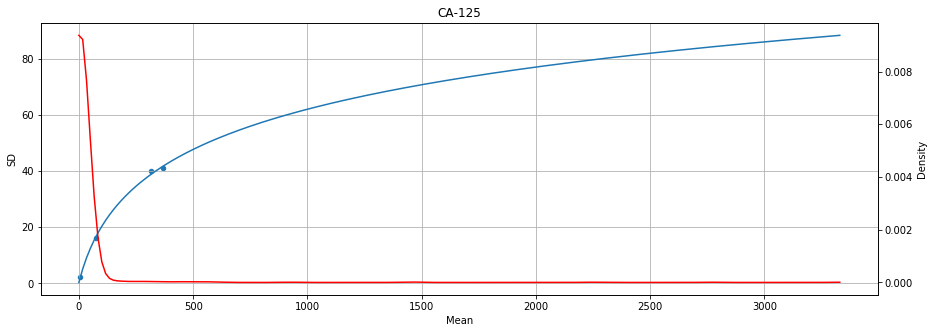

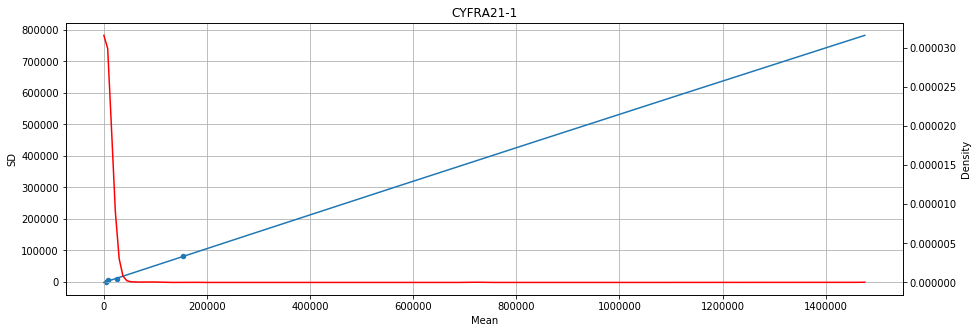

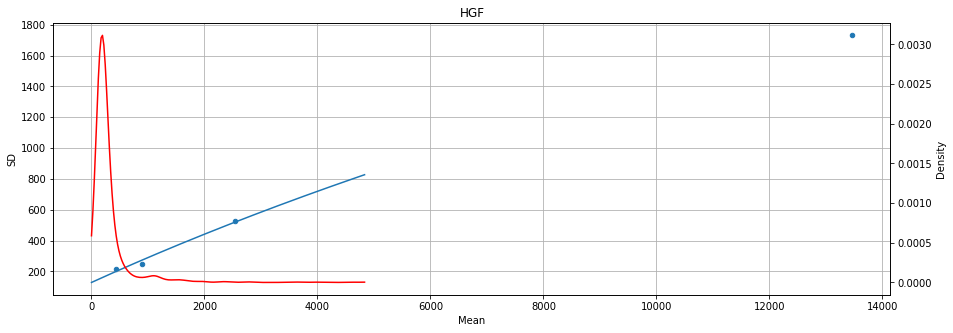

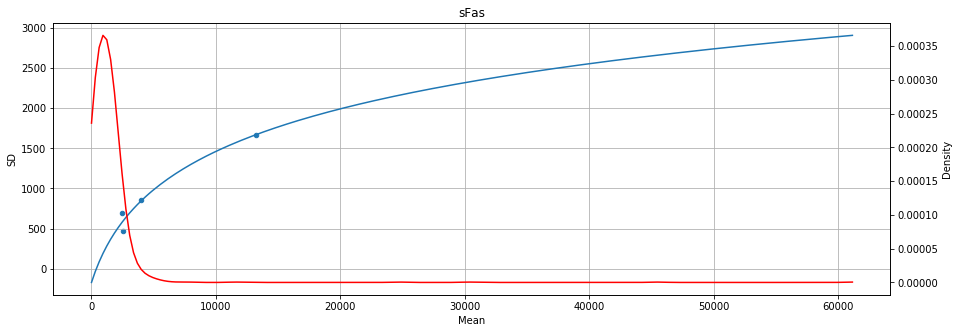

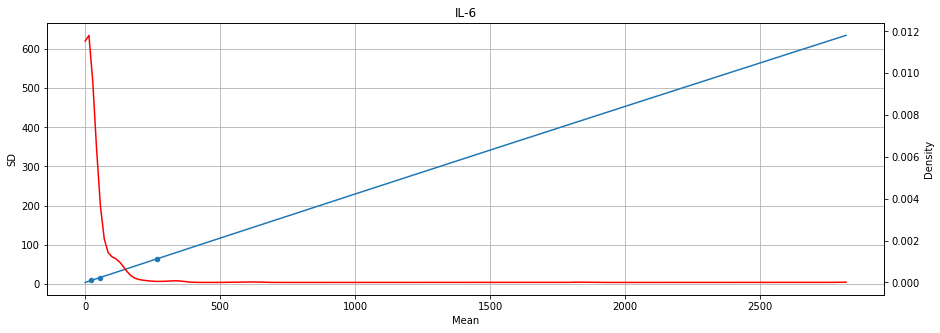

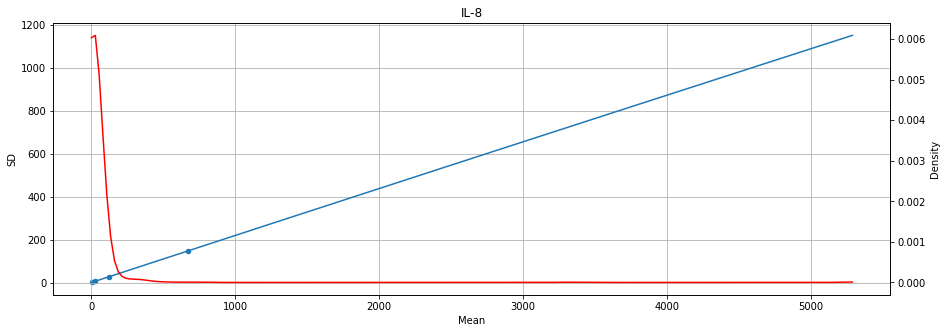

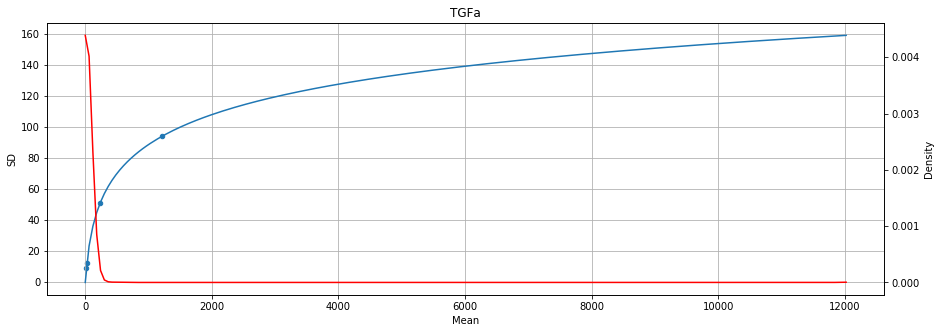

In [8]:
def log_func(x, a, b, c):
    #     c=0
    return a*np.log(x+c)+b
#     return (a/x)+b


for c, i in zip(features[1], features_name):
    d = cv_data.loc[i].dropna()
    d['SD'] = d["Mean"]*d["CV"]/100
    ax = d.plot(kind='scatter', x='Mean', y='SD',
                title=i, figsize=(15, 5), grid=True)
#     d.plot(kind='scatter', x='Mean', y='SD', ax=ax,color='g')
    p, _ = optimize.curve_fit(
        log_func, d.values[:, 0], d.values[:, 2], maxfev=20000)
    x = np.linspace(0, dataset[0][c].max(), num=200)
    plt.plot(x, log_func(x, *p))
    x = np.linspace(0, dataset[0][c].max(), num=200)
    dataset[0][c].plot.kde(ax=ax.twinx(), ind=x, color='r')

# Model

In [47]:
dataset_ = copy.deepcopy(dataset)
for i in range(3):
    dataset_[i]['S1'] = (dataset_[i].T2 > 0).astype(int)
    dataset_[i]['S2'] = (dataset_[i].T2 > 1).astype(int)
    dataset_[i]['S3'] = (dataset_[i].T2 > 2).astype(int)

for i in range(3):
    dataset_[i] = dataset_[i].dropna(subset=data_set).copy()
transformer = {
    myprep.age_transformer(): ['F1'],
    skprep.OrdinalEncoder(): ['F2'],
    skprep.QuantileTransformer(): features[1]
}
transformer = myprep.PipeTransform(transformer, dataset_[0])
dataset_trans = copy.deepcopy(dataset_)
for i in range(3):
    dataset_trans[i] = transformer.transform(dataset_[i])

X_train = myhandles.dataset_generator(dataset_trans[0], features)
X_dev = myhandles.dataset_generator(dataset_trans[1], features)
Y_train = myhandles.dataset_generator(dataset_trans[0], targets)
Y_dev = myhandles.dataset_generator(dataset_trans[1], targets)
X_pnas = myhandles.dataset_generator(dataset_trans[2], features)

## base

In [10]:
reg = 0.005

in_demo = klayers.Input(shape=(2,))
in_prot = klayers.Input(shape=(X_train[1].shape[1],))
l1 = klayers.BatchNormalization()(in_demo)
l1 = klayers.Dense(8, activation='selu',
                   kernel_initializer='lecun_normal', kernel_regularizer=kregularizers.l2(reg))(l1)
l2 = klayers.BatchNormalization()(in_prot)
l2 = klayers.Dense(16, activation='selu',
                   kernel_initializer='lecun_normal', kernel_regularizer=kregularizers.l2(reg))(l2)
l = klayers.Concatenate()([l1, l2])
l = klayers.Dense(16, activation='selu', kernel_initializer='lecun_normal',
                  kernel_regularizer=kregularizers.l2(reg))(l)

S1 = klayers.Dense(1, activation='sigmoid', name="S1")(l)
S2_1 = klayers.Dense(1, activation='sigmoid', name="S2_1")(l)
S3_2 = klayers.Dense(1, activation='sigmoid', name="S3_2")(l)
S2 = klayers.Multiply(name='S2')([S2_1, S1])
S3 = klayers.Multiply(name='S3')([S3_2, S2])
stage_out = klayers.Concatenate(name='stage_out')([S1, S2, S3])

model_base = kmodels.Model(inputs=[in_demo, in_prot], outputs=[stage_out])
model_base.compile('adam', ['binary_crossentropy'])
es = kcallbacks.EarlyStopping(patience=10)
h = model_base.fit(X_train, Y_train, batch_size=32, epochs=1000,
                   validation_data=(X_dev, Y_dev), callbacks=[es])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 1131 samples, validate on 368 samples
Epoch 1/1000
1131/1131 [==============================] - 1s 1ms/step - loss: 0.8071 - val_loss: 0.6755
Epoch 2/1000
1131/1131 [==============================] - 0s 123us/step - loss: 0.6420 - val_loss: 0.5943
Epoch 3/1000
1131/1131 [==============================] - 0s 121us/step - loss: 0.5892 - val_loss: 0.5532
Epoch 4/1000
1131/1131 [==============================] - 0s 122us/step - loss: 0.5584 - val_loss: 0.5276
Epoch 5/1000
1131/1131 [==============================] - 0s 124us/step - loss: 0.5382 - val_loss: 0.5088
Epoch 6/1000
1131/1131 [==============================] - 0s 175us/step - loss: 0.5200 - val_loss: 0.4936
Epoch 7/1000
1131/1131 [==============================] - 0s 133us/step - loss: 0.5024 - val_loss: 0.4812
Epoch 8/1000
1131/1131 [==============================] - 0s 149us/step - loss: 0.4932 - val_

Epoch 72/1000
1131/1131 [==============================] - 0s 162us/step - loss: 0.3567 - val_loss: 0.3482
Epoch 73/1000
1131/1131 [==============================] - 0s 157us/step - loss: 0.3601 - val_loss: 0.3487
Epoch 74/1000
1131/1131 [==============================] - 0s 145us/step - loss: 0.3601 - val_loss: 0.3491
Epoch 75/1000
1131/1131 [==============================] - 0s 145us/step - loss: 0.3514 - val_loss: 0.3505
Epoch 76/1000
1131/1131 [==============================] - 0s 147us/step - loss: 0.3497 - val_loss: 0.3483
Epoch 77/1000
1131/1131 [==============================] - 0s 139us/step - loss: 0.3507 - val_loss: 0.3487
Epoch 78/1000
1131/1131 [==============================] - 0s 143us/step - loss: 0.3469 - val_loss: 0.3477
Epoch 79/1000
1131/1131 [==============================] - 0s 140us/step - loss: 0.3513 - val_loss: 0.3480
Epoch 80/1000
1131/1131 [==============================] - 0s 145us/step - loss: 0.3468 - val_loss: 0.3484
Epoch 81/1000
1131/1131 [============

1131/1131 [==============================] - 0s 164us/step - loss: 0.3238 - val_loss: 0.3316
Epoch 149/1000
1131/1131 [==============================] - 0s 165us/step - loss: 0.3336 - val_loss: 0.3302
Epoch 150/1000
1131/1131 [==============================] - 0s 172us/step - loss: 0.3235 - val_loss: 0.3301
Epoch 151/1000
1131/1131 [==============================] - 0s 167us/step - loss: 0.3387 - val_loss: 0.3276
Epoch 152/1000
1131/1131 [==============================] - 0s 150us/step - loss: 0.3252 - val_loss: 0.3291
Epoch 153/1000
1131/1131 [==============================] - 0s 158us/step - loss: 0.3233 - val_loss: 0.3285
Epoch 154/1000
1131/1131 [==============================] - 0s 167us/step - loss: 0.3232 - val_loss: 0.3310
Epoch 155/1000
1131/1131 [==============================] - 0s 158us/step - loss: 0.3225 - val_loss: 0.3295
Epoch 156/1000
1131/1131 [==============================] - 0s 146us/step - loss: 0.3275 - val_loss: 0.3259
Epoch 157/1000
1131/1131 [=================

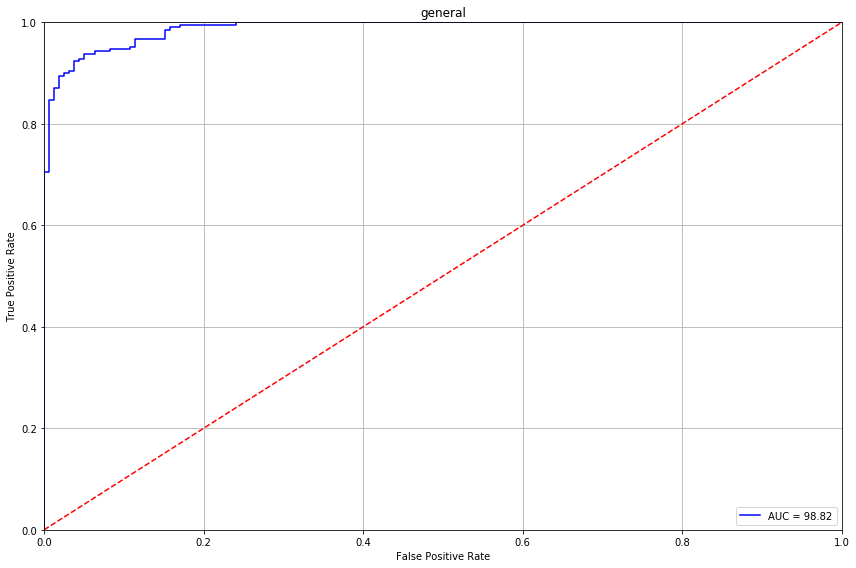

PNAS controls result:


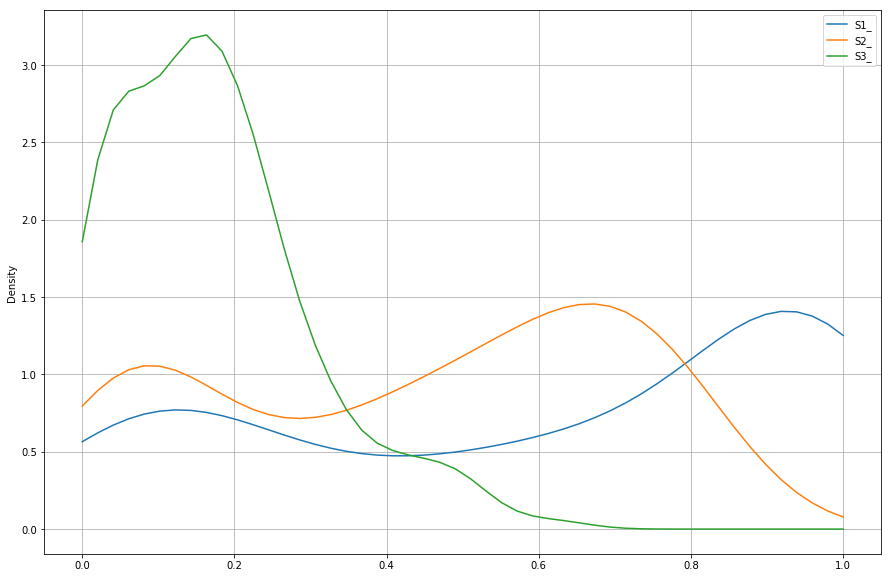

S1_: 115.0 of 180 | error = 0.6388888888888888 | log-loss = 1.9109894


,S1_,S2_,S3_
count,180.000000,180.000000,180.000000
mean,0.615916,0.445714,0.170211
std,0.355553,0.269175,0.125902
min,0.008002,0.005780,0.003027
25%,0.240080,0.159169,0.067106
50%,0.737890,0.497756,0.151479
75%,0.956743,0.686594,0.230727
max,0.999766,0.859778,0.620668


In [11]:
res_base = dataset_trans[1].copy()
res_base['S1_'], res_base['S2_'], res_base['S3_'] = None, None, None
res_base[['S1_', 'S2_', 'S3_']] = model_base.predict(X_dev)
plt.figure(figsize=(15, 10))
myplots.training_plot(h.history)
myplots.binroc_multiple(res_base, 'S1', 'S1_', 'T1', cancer_sets, normal_set)
plt.show()
# -------------------------------
print('PNAS controls result:')
res_pnas_base = model_base.predict(X_pnas)
res_pnas_base = pd.DataFrame(res_pnas_base, columns=['S1_', 'S2_', 'S3_'])
res_pnas_base.plot.kde(grid=True, figsize=(15, 10), ind=np.linspace(0, 1, 50))
plt.show()
res_pnas_base.describe()
pnas_bool = np.round(res_pnas_base['S1_'])
print('S1_:', pnas_bool.sum(), 'of', len(res_pnas_base), '| error =', pnas_bool.sum(
)/len(pnas_bool), '| log-loss =', -np.log(1-res_pnas_base['S1_']).mean())
res_pnas_base.describe()

## Constant noise Generator 

In [42]:
class ConstantGen(kutils.Sequence):

    def __init__(self, x, y, cv, transformer, batch_size=32):
        self.x0, self.y = x[0].copy(), y.copy()
        self.transformer = transformer.processor[-1]
        self.x1_raw = self.transformer.inverse_transform(x[1])
        self.batch_size = batch_size
        self.cv = cv
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.x0) / float(self.batch_size)))

    def __getitem__(self, idx):
        indexes = self.meta_index[idx *
                                  self.batch_size:(idx + 1) * self.batch_size]
        batch_x = [self.x0[indexes, :], self.x1[indexes, :]]
        batch_y = [self.y[0][indexes]]
        return batch_x, batch_y

    def on_epoch_end(self):
        self.meta_index = np.random.permutation(len(self.x0))
        self.x1 = np.random.normal(self.x1_raw, self.x1_raw*self.cv)
        self.x1 = self.transformer.transform(self.x1)

In [54]:
reg = 0.005

in_demo = klayers.Input(shape=(2,))
in_prot = klayers.Input(shape=(X_train[1].shape[1],))
l1 = klayers.BatchNormalization()(in_demo)
l1 = klayers.Dense(8, activation='selu',
                   kernel_initializer='lecun_normal', kernel_regularizer=kregularizers.l2(reg))(l1)
l2 = klayers.BatchNormalization()(in_prot)
l2 = klayers.Dense(16, activation='selu',
                   kernel_initializer='lecun_normal', kernel_regularizer=kregularizers.l2(reg))(l2)
l = klayers.Concatenate()([l1, l2])
l = klayers.Dense(16, activation='selu', kernel_initializer='lecun_normal',
                  kernel_regularizer=kregularizers.l2(reg))(l)

S1 = klayers.Dense(1, activation='sigmoid', name="S1")(l)
S2_1 = klayers.Dense(1, activation='sigmoid', name="S2_1")(l)
S3_2 = klayers.Dense(1, activation='sigmoid', name="S3_2")(l)
S2 = klayers.Multiply(name='S2')([S2_1, S1])
S3 = klayers.Multiply(name='S3')([S3_2, S2])
stage_out = klayers.Concatenate(name='stage_out')([S1, S2, S3])

model_G1 = kmodels.Model(inputs=[in_demo, in_prot], outputs=[stage_out])
model_G1.compile('adam', ['binary_crossentropy'])
es = kcallbacks.EarlyStopping(patience=50)
gen = ConstantGen(X_train, Y_train, 4, transformer=transformer,)
h = model_G1.fit_generator(gen, epochs=1000, validation_data=(
    X_dev, Y_dev), callbacks=[es], shuffle=True)

Epoch 1/1000
36/36 [==============================] - 2s 48ms/step - loss: 0.8699 - val_loss: 0.7228
Epoch 2/1000
36/36 [==============================] - 0s 6ms/step - loss: 0.7825 - val_loss: 0.6745
Epoch 3/1000
36/36 [==============================] - 0s 7ms/step - loss: 0.7266 - val_loss: 0.6503
Epoch 4/1000
36/36 [==============================] - 0s 8ms/step - loss: 0.7094 - val_loss: 0.6405
Epoch 5/1000
36/36 [==============================] - 0s 8ms/step - loss: 0.6907 - val_loss: 0.6260
Epoch 6/1000
36/36 [==============================] - 0s 7ms/step - loss: 0.6840 - val_loss: 0.6159
Epoch 7/1000
36/36 [==============================] - 0s 9ms/step - loss: 0.6730 - val_loss: 0.6047
Epoch 8/1000
36/36 [==============================] - 0s 7ms/step - loss: 0.6576 - val_loss: 0.5903
Epoch 9/1000
36/36 [==============================] - 0s 8ms/step - loss: 0.6508 - val_loss: 0.5794
Epoch 10/1000
36/36 [==============================] - 0s 8ms/step - loss: 0.6409 - val_loss: 0.571

36/36 [==============================] - 0s 8ms/step - loss: 0.5321 - val_loss: 0.4780
Epoch 163/1000
36/36 [==============================] - 0s 7ms/step - loss: 0.5317 - val_loss: 0.4672
Epoch 164/1000
36/36 [==============================] - 0s 8ms/step - loss: 0.5269 - val_loss: 0.4664
Epoch 165/1000
36/36 [==============================] - 0s 7ms/step - loss: 0.5125 - val_loss: 0.4629
Epoch 166/1000
36/36 [==============================] - 0s 8ms/step - loss: 0.5221 - val_loss: 0.4620
Epoch 167/1000
36/36 [==============================] - 0s 7ms/step - loss: 0.5292 - val_loss: 0.4676
Epoch 168/1000
36/36 [==============================] - 0s 7ms/step - loss: 0.5227 - val_loss: 0.4668
Epoch 169/1000
36/36 [==============================] - 0s 7ms/step - loss: 0.5230 - val_loss: 0.4756
Epoch 170/1000
36/36 [==============================] - 0s 6ms/step - loss: 0.5250 - val_loss: 0.4662
Epoch 171/1000
36/36 [==============================] - 0s 8ms/step - loss: 0.5198 - val_loss: 0.

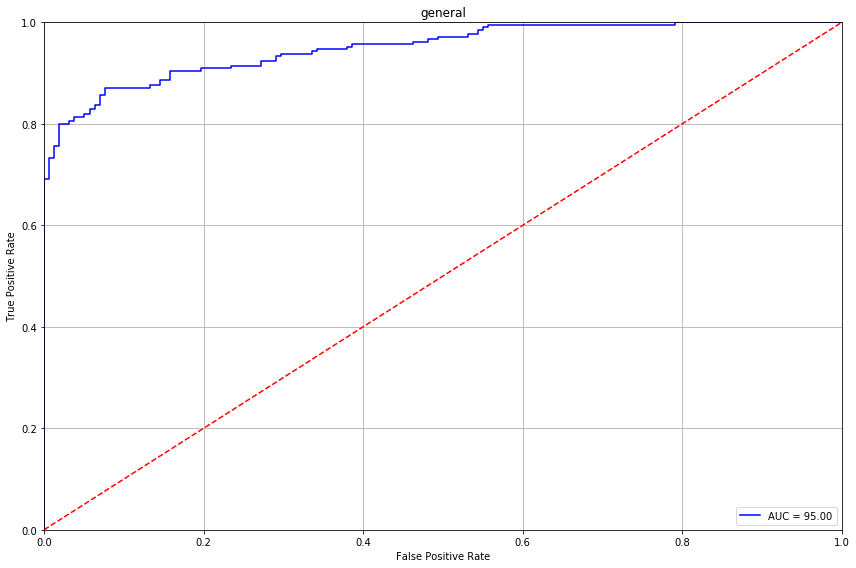

PNAS controls result:


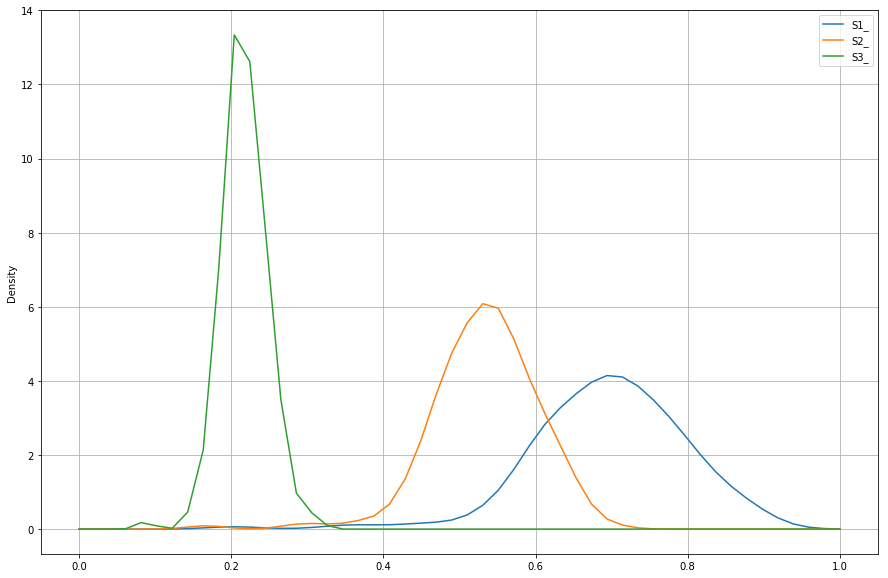

S1_: 175.0 of 180 | error = 0.9722222222222222 | log-loss = 1.2441164


,S1_,S2_,S3_
count,180.000000,180.000000,180.000000
mean,0.695691,0.533063,0.217276
std,0.100015,0.069599,0.029514
min,0.204209,0.167465,0.088105
25%,0.632817,0.492546,0.199885
50%,0.699048,0.537552,0.215076
75%,0.761732,0.578542,0.234856
max,0.903077,0.698439,0.312913


In [55]:
res_g1 = dataset_trans[1].copy()
res_g1['S1_'], res_g1['S2_'], res_g1['S3_'] = None, None, None
res_g1[['S1_', 'S2_', 'S3_']] = model_G1.predict(X_dev)
plt.figure(figsize=(15, 10))
myplots.training_plot(h.history)
myplots.binroc_multiple(res_g1, 'S1', 'S1_', 'T1', cancer_sets, normal_set)
plt.show()
# -------------------------------
print('PNAS controls result:')
res_pnas_g1 = model_G1.predict(X_pnas)
res_pnas_g1 = pd.DataFrame(res_pnas_g1, columns=['S1_', 'S2_', 'S3_'])
res_pnas_g1.plot.kde(grid=True, figsize=(15, 10), ind=np.linspace(0, 1, 50))
plt.show()
res_pnas_g1.describe()
pnas_bool = np.round(res_pnas_g1['S1_'])
print('S1_:', pnas_bool.sum(), 'of', len(res_pnas_g1), '| error =', pnas_bool.sum(
)/len(pnas_bool), '| log-loss =', -np.log(1-res_pnas_g1['S1_']).mean())
res_pnas_g1.describe()

## Interassay noise

In [42]:
class IntertGen(kutils.Sequence):

    def __init__(self, x, y, cv, transformer, batch_size=32):
        self.x0, self.y = x[0].copy(), y.copy()
        self.transformer = transformer.processor[-1]
        self.x1_raw = self.transformer.inverse_transform(x[1])
        self.batch_size = batch_size
        self.cv = cv
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.x0) / float(self.batch_size)))

    def __getitem__(self, idx):
        indexes = self.meta_index[idx *
                                  self.batch_size:(idx + 1) * self.batch_size]
        batch_x = [self.x0[indexes, :], self.x1[indexes, :]]
        batch_y = [self.y[0][indexes]]
        return batch_x, batch_y

    def on_epoch_end(self):
        self.meta_index = np.random.permutation(len(self.x0))
        self.x1 = np.random.normal(self.x1_raw, self.x1_raw*self.cv)
        self.x1 = self.transformer.transform(self.x1)

In [56]:
reg = 0.001

in_demo = klayers.Input(shape=(2,))
in_prot = klayers.Input(shape=(X_train[1].shape[1],))
l1 = klayers.BatchNormalization()(in_demo)
l1 = klayers.Dense(8, activation='selu',
                   kernel_initializer='lecun_normal', kernel_regularizer=kregularizers.l2(reg))(l1)
l2 = klayers.BatchNormalization()(in_prot)
l2 = klayers.Dense(16, activation='selu',
                   kernel_initializer='lecun_normal', kernel_regularizer=kregularizers.l2(reg))(l2)
l = klayers.Concatenate()([l1, l2])
l = klayers.Dense(16, activation='selu', kernel_initializer='lecun_normal',
                  kernel_regularizer=kregularizers.l2(reg))(l)

S1 = klayers.Dense(1, activation='sigmoid', name="S1")(l)
S2_1 = klayers.Dense(1, activation='sigmoid', name="S2_1")(l)
S3_2 = klayers.Dense(1, activation='sigmoid', name="S3_2")(l)
S2 = klayers.Multiply(name='S2')([S2_1, S1])
S3 = klayers.Multiply(name='S3')([S3_2, S2])
stage_out = klayers.Concatenate(name='stage_out')([S1, S2, S3])

model_G1 = kmodels.Model(inputs=[in_demo, in_prot], outputs=[stage_out])
model_G1.compile('adam', ['binary_crossentropy'])
es = kcallbacks.EarlyStopping(patience=50)
gen = ConstantGen(X_train, Y_train, 2, transformer=transformer,)
h = model_G1.fit_generator(gen, epochs=1000, validation_data=(
    X_dev, Y_dev), callbacks=[es], shuffle=True)

Epoch 1/1000
36/36 [==============================] - 2s 51ms/step - loss: 1.0017 - val_loss: 0.7596
Epoch 2/1000
36/36 [==============================] - 0s 6ms/step - loss: 0.8104 - val_loss: 0.7001
Epoch 3/1000
36/36 [==============================] - 0s 7ms/step - loss: 0.7540 - val_loss: 0.6726
Epoch 4/1000
36/36 [==============================] - 0s 7ms/step - loss: 0.7332 - val_loss: 0.6520
Epoch 5/1000
36/36 [==============================] - 0s 9ms/step - loss: 0.7186 - val_loss: 0.6364
Epoch 6/1000
36/36 [==============================] - 0s 7ms/step - loss: 0.7013 - val_loss: 0.6187
Epoch 7/1000
36/36 [==============================] - 0s 8ms/step - loss: 0.6863 - val_loss: 0.5977
Epoch 8/1000
36/36 [==============================] - 0s 7ms/step - loss: 0.6716 - val_loss: 0.5848
Epoch 9/1000
36/36 [==============================] - 0s 7ms/step - loss: 0.6576 - val_loss: 0.5706
Epoch 10/1000
36/36 [==============================] - 0s 7ms/step - loss: 0.6494 - val_loss: 0.559

36/36 [==============================] - 0s 7ms/step - loss: 0.5022 - val_loss: 0.4198
Epoch 163/1000
36/36 [==============================] - 0s 7ms/step - loss: 0.5039 - val_loss: 0.4306
Epoch 164/1000
36/36 [==============================] - 0s 8ms/step - loss: 0.5048 - val_loss: 0.4376
Epoch 165/1000
36/36 [==============================] - 0s 6ms/step - loss: 0.5027 - val_loss: 0.4284
Epoch 166/1000
36/36 [==============================] - 0s 7ms/step - loss: 0.5047 - val_loss: 0.4304
Epoch 167/1000
36/36 [==============================] - 0s 7ms/step - loss: 0.5044 - val_loss: 0.4319
Epoch 168/1000
36/36 [==============================] - 0s 8ms/step - loss: 0.5049 - val_loss: 0.4300
Epoch 169/1000
36/36 [==============================] - 0s 7ms/step - loss: 0.5071 - val_loss: 0.4318
Epoch 170/1000
36/36 [==============================] - 0s 7ms/step - loss: 0.5119 - val_loss: 0.4337
Epoch 171/1000
36/36 [==============================] - 0s 7ms/step - loss: 0.5108 - val_loss: 0.

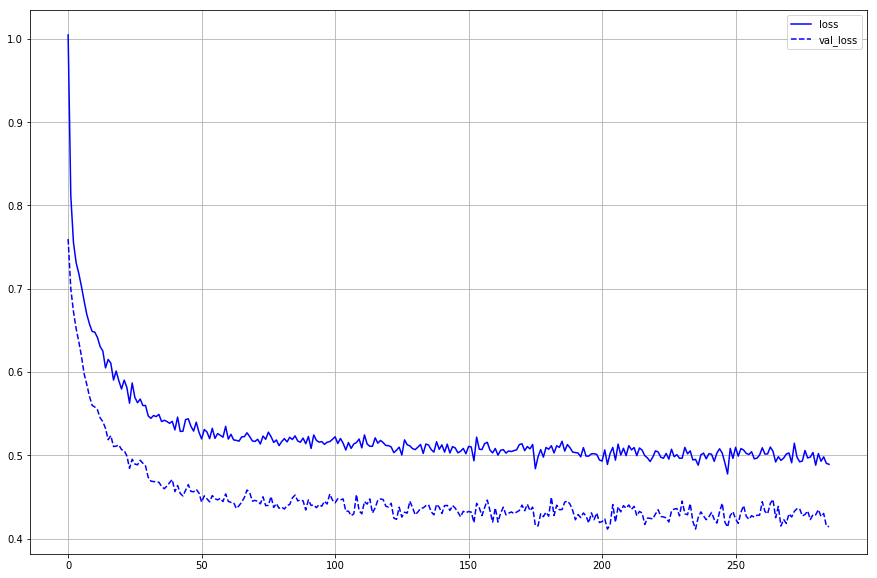

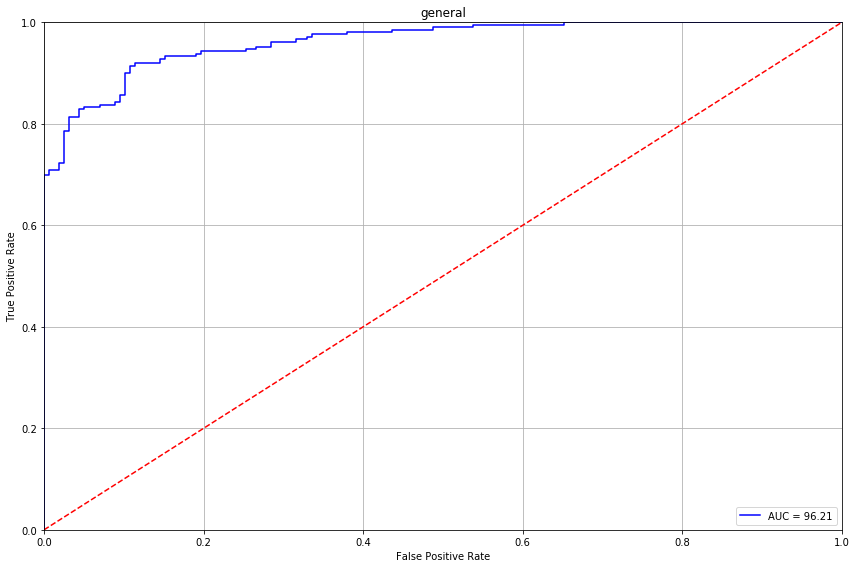

PNAS controls result:


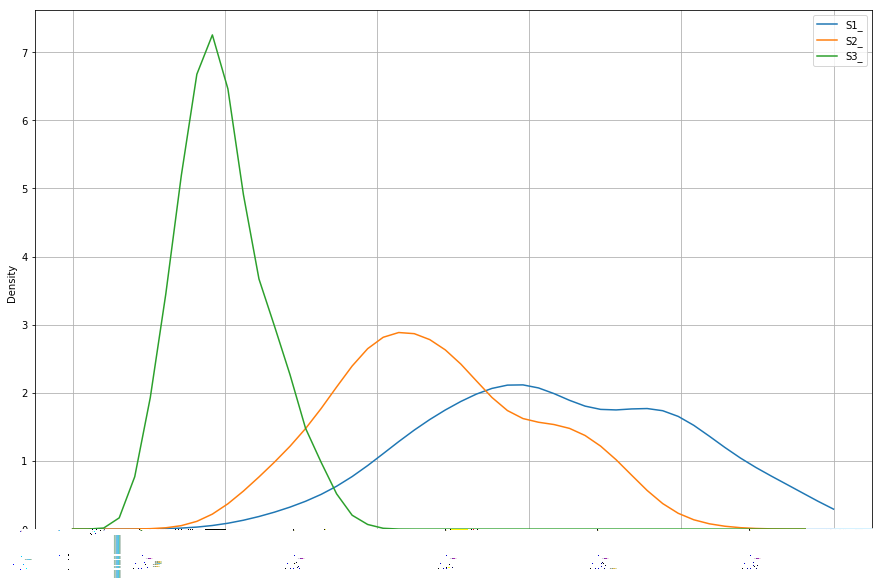

S1_: 140.0 of 180 | error = 0.7777777777777778 | log-loss = 1.160272


,S1_,S2_,S3_
count,180.000000,180.000000,180.000000
mean,0.635843,0.480103,0.197420
std,0.165851,0.131589,0.056182
min,0.249860,0.225446,0.089158
25%,0.522124,0.384680,0.156185
50%,0.619121,0.469751,0.188363
75%,0.767080,0.572421,0.229963
max,0.975392,0.809759,0.365769


In [57]:
res_g1 = dataset_trans[1].copy()
res_g1['S1_'], res_g1['S2_'], res_g1['S3_'] = None, None, None
res_g1[['S1_', 'S2_', 'S3_']] = model_G1.predict(X_dev)
plt.figure(figsize=(15, 10))
myplots.training_plot(h.history)
myplots.binroc_multiple(res_g1, 'S1', 'S1_', 'T1', cancer_sets, normal_set)
plt.show()
# -------------------------------
print('PNAS controls result:')
res_pnas_g1 = model_G1.predict(X_pnas)
res_pnas_g1 = pd.DataFrame(res_pnas_g1, columns=['S1_', 'S2_', 'S3_'])
res_pnas_g1.plot.kde(grid=True, figsize=(15, 10), ind=np.linspace(0, 1, 50))
plt.show()
res_pnas_g1.describe()
pnas_bool = np.round(res_pnas_g1['S1_'])
print('S1_:', pnas_bool.sum(), 'of', len(res_pnas_g1), '| error =', pnas_bool.sum(
)/len(pnas_bool), '| log-loss =', -np.log(1-res_pnas_g1['S1_']).mean())
res_pnas_g1.describe()